In [66]:
import os, sys
sys.path.insert(0, os.path.dirname(os.getcwd()))
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'DeepUnitMatch'))
import UnitMatchPy.default_params as default_params
import UnitMatchPy.utils as util
import UnitMatchPy.overlord as ov
import UnitMatchPy.bayes_functions as bf
import matplotlib.pyplot as plt
import numpy as np
from DeepUnitMatch.utils import param_fun
from DeepUnitMatch.testing import test
from DeepUnitMatch.preprocess import split_units
import UnitMatchPy.assign_unique_id as aid
import UnitMatchPy.save_utils as su
from DeepUnitMatch.testing import naive_bayes

In [2]:
# Getting the data the same way as UnitMatch

# Get default parameters, can add your own before or after!
param = default_params.get_default_param()

# Give the paths to the KS directories for each session
# If you don't have a dir with channel_positions.npy etc look at the detailed example for supplying paths separately 
KS_dirs = [r'\\znas\Subjects\AL032\2019-11-21\ephys_K1\pyKS\output', r'\\znas\Subjects\AL032\2019-11-22\ephys_K1\pyKS\output', 
           r'\\znas\Subjects\AL032\2019-12-03\ephys_K1\pyKS\output', r'\\znas\Subjects\AL032\2019-12-04\ephys_K1\AL032_2019-12-04_stripe192_gratings_g0\AL032_2019-12-04_stripe192_gratings_g0_imec0\pyKS\output']

param['KS_dirs'] = KS_dirs
wave_paths, unit_label_paths, channel_pos = util.paths_from_KS(KS_dirs)
param = util.get_probe_geometry(channel_pos[0], param)

# STEP 0 from the UMPy example notebook
waveform, session_id, session_switch, within_session, good_units, param = util.load_good_waveforms(wave_paths, unit_label_paths, param, good_units_only = True)
param['good_units'] = good_units

Using BombCell: cluster_bc_unitType
Using BombCell: cluster_bc_unitType
Using BombCell: cluster_bc_unitType
Using BombCell: cluster_bc_unitType


In [9]:
# Preprocess the DeepUnitMatch way and save as HDF5 files for each session in 'processed_waveforms'.
snippets, positions = param_fun.get_snippets(waveform, channel_pos, session_id)

# Load the neural net
model = test.load_trained_model(device="cpu")

# We have stored the preprocessed data here (from the get_snippets function)
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'DeepUnitMatch', 'processed_waveforms')

# Pass the preprocessed data through the neural net
sim_matrix = test.inference(model, data_dir)

C:\Users\suyash\UCL\DeepUnitMatch\DeepUnitMatch\UnitMatchPy\DeepUnitMatch\processed_waveforms is the data directory
Initialised with 695 files in the dataset.
No. of experiment batches: 4


100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


In [25]:
# Optionally, you can remove split units to get cleaner data and results. This detects where spike sorting may have split units and merges them back together.

merged_sim_matrix, merged_param, merged_session_id, merged_session_switch = split_units.merge_and_remove_splits(param, sim_matrix, session_id, model, data_dir)

# If you want to go ahead with the results of merging,
sim_matrix = merged_sim_matrix
param = merged_param
session_id = merged_session_id
session_switch = merged_session_switch

# If you change your mind, you can also undo the merge:
# split_units.undo_merge(data_dir)
# You will need to recompute the above variables if you changed them (sim_matrix, param, session_id, session_switch) after merging.

Units to remove: 0
Unit to merge: 0
No units to merge or remove. Exiting.


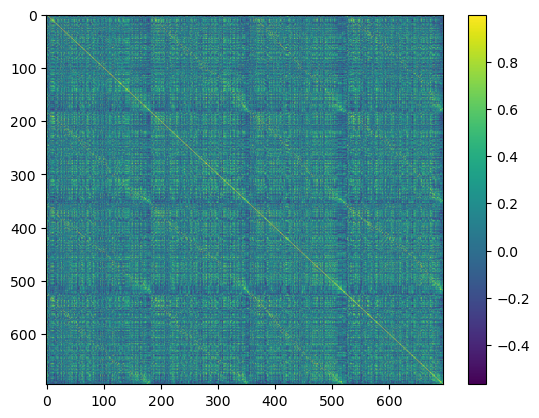

In [26]:
# Visualise the similarity matrix
plt.imshow(sim_matrix, cmap='viridis', aspect='auto')
plt.colorbar()

In [68]:
# STEP 1
# Extract parameters from waveform. We only need the distance matrix in DeepUnitMatch.
clus_info = {'good_units' : param['good_units'], 'session_switch' : session_switch, 'session_id' : session_id, 
            'original_ids' : np.concatenate(param['good_units']) }
extracted_wave_properties = ov.extract_parameters(waveform, channel_pos, clus_info, param)                  # contains spatial locations
within_session = 1 - (session_id[:, None] == session_id).astype(int)
distance_matrix, candidate_pairs, scores_to_include, predictors  = ov.extract_metric_scores(extracted_wave_properties, session_switch, within_session, param, 
                                                                                        niter  = 2, to_use=['centroid_dist'])

100%|██████████| 483025/483025 [01:34<00:00, 5089.00it/s]


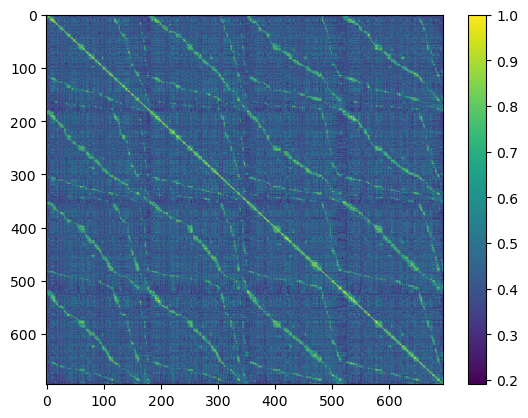

In [69]:
# Put distances and similarity scores into Naive Bayes model to get final predicted probabilities

probs = naive_bayes.nb_matrices(sim_matrix, distance_matrix, session_id)
plt.imshow(probs, cmap='viridis', aspect='auto')
plt.colorbar()

In [61]:
# Use the same Naive Bayes as in UnitMatchPy

# Get prior probability of being a match
prior_match = 1 - (param['n_expected_matches'] / param['n_units']**2 ) # freedom of choose in prior prob
priors = np.array((prior_match, 1-prior_match))
labels = candidate_pairs.astype(int)
cond = np.unique(labels)
parameter_kernels = bf.get_parameter_kernels(scores_to_include, labels, cond, param, add_one = 1)
probability = bf.apply_naive_bayes(parameter_kernels, priors, predictors, param, cond)
output_prob_matrix = probability[:,1].reshape(param['n_units'],param['n_units'])

Calculating the probability distributions of the metric scores
Calculating the match probabilities


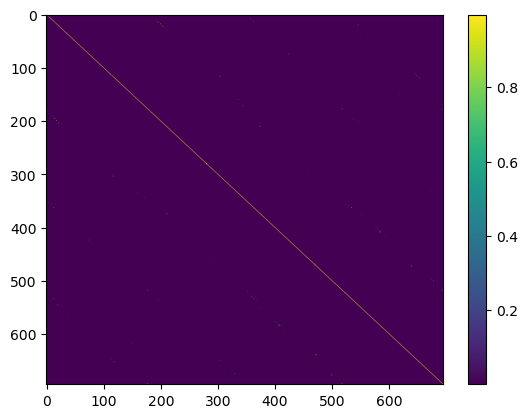

In [62]:
# Visualise the output probability matrix

plt.imshow(output_prob_matrix, cmap='viridis', aspect='auto')
plt.colorbar()

In [48]:
# UnitMatchPy evaluation function

# util.evaluate_output(output_prob_matrix, param, within_session, session_switch, match_threshold = 0.5)

# to test my NB method, replace output_prob_matrix with probs
util.evaluate_output(probs, param, within_session, session_switch, match_threshold = 0.9)

The percentage of units matched to themselves is: 100.00%
The percentage of false -ve's then is: 0.00% 

The rate of miss-match(es) per expected match 1.68
The percentage of false +ve's is 0.00% for session 1
The percentage of false +ve's is 0.00% for session 2
The percentage of false +ve's is 0.00% for session 3
The percentage of false +ve's is 0.00% for session 4

This assumes that the spike sorter has made no mistakes


 Found 415 matches in this pair of sessions using the threshold of 0.9. Total number of units: 695


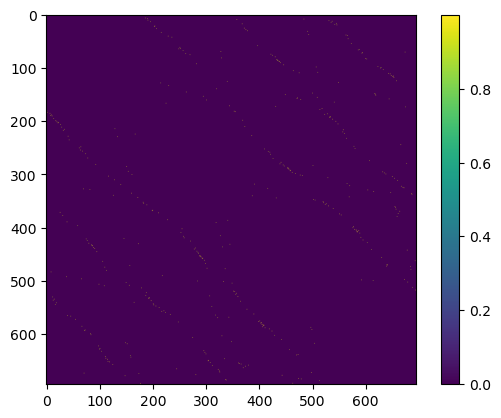

In [65]:
# Process the output probability matrix to get final set of matches (across sessions)
param['match_threshold'] = 0.9
probs_, final_matches = test.get_final_matches(probs, session_id, param['match_threshold'])
plt.imshow(probs_, cmap='viridis')
plt.colorbar()
print(f" Found {np.sum(final_matches)} matches in this pair of sessions using the threshold of {param['match_threshold']}. Total number of units: {param['n_units']}")

In [59]:
# Now we can check performance using the AUC. This tests the agreement between DeepUnitMatch matches and functional scores (in this case, ISI histogram correlations).

isicorr = test.ISI_correlations(param)
auc = test.AUC(final_matches, isicorr, session_id)
print(f"AUC for DeepUnitMatch matches: {auc:.3f}")

100%|██████████| 171/171 [00:00<00:00, 391.43it/s]


AUC for DeepUnitMatch matches: 0.496


In [16]:
# Finally, we can do tracking using the UnitMatch tracking function. This assigns unique IDs to the neurons that will persist across many sessions.

UIDs = aid.assign_unique_id(output_prob_matrix, param, clus_info)

# Save the results
save_dir = r"C:\Users\suyash\UCL\DeepUnitMatch\scratch_data"
amplitude = extracted_wave_properties['amplitude']
spatial_decay = extracted_wave_properties['spatial_decay']
avg_centroid = extracted_wave_properties['avg_centroid']
avg_waveform = extracted_wave_properties['avg_waveform']
avg_waveform_per_tp = extracted_wave_properties['avg_waveform_per_tp']
wave_idx = extracted_wave_properties['good_wave_idxs']
max_site = extracted_wave_properties['max_site']
max_site_mean = extracted_wave_properties['max_site_mean']
su.save_to_output(save_dir, scores_to_include, np.argwhere(final_matches), output_prob_matrix, avg_centroid, avg_waveform, avg_waveform_per_tp, max_site,
                   distance_matrix, final_matches, clus_info, param, UIDs = UIDs, matches_curated = None, save_match_table = True)

Number of Liberal Matches: 164
Number of Intermediate Matches: 139
Number of Conservative Matches: 139
